In [1]:
import pandas as pd
import numpy as np
from KRData.HKData import *
from KRData.util import draw_klines
from ib_insync import *
import datetime as dt
from IPython.display import display, clear_output
import sys

d:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
hf = HKFuture('krdata', 'kairuitouzi')

In [3]:
data = hf.get_main_contract_bars('HSI', start='20181201') # 获取需要对照的历史K线

In [4]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7496,clientId=9)
hsi1904 = Future('HSI', '201904')
ib.qualifyContracts(hsi1904)

[Future(conId=355299154, symbol='HSI', lastTradeDateOrContractMonth='20190429', multiplier='50', exchange='HKFE', currency='HKD', localSymbol='HSIJ9', tradingClass='HSI')]

In [5]:
mkData = ib.reqHistoricalData(hsi1904, '', f'{60*100} S', '1 min', 'TRADES', useRTH=False, keepUpToDate=True)

In [6]:
def analyze(targetData: pd.DataFrame, sourceData: pd.DataFrame, corrThreshold=0.8):
    targetSize = len(targetData)
    sourceSize = len(sourceData)
    ret = []
    for i in range(sourceSize-targetSize):
        sc = sourceData[i:i+targetSize]
        corr=np.corrcoef(targetData, sc)[0][1]
        ret.append([sc.index[0], sc.index[-1], corr])
    
    gt_threshold = [r for r in ret if r[-1]>corrThreshold]
    
    # 过滤连续K线高相关
    filtedRet = []
    if len(gt_threshold)>=2:
        r=gt_threshold[0]
        for i in range(len(gt_threshold)-1):
            if (gt_threshold[i+1][1] -gt_threshold[i][0])*0.9<=(gt_threshold[i][1] -gt_threshold[i+1][0]):
                r =gt_threshold[i+1] if gt_threshold[i+1][-1]>r[-1] else r
            else:
                filtedRet.append(r)
                r=gt_threshold[i+1]
        else:
            filtedRet.append(r)
    else:
        filtedRet = gt_threshold
        
    return filtedRet

In [7]:
def analyzeHistoricalData(bars, hasNewBar):
    if hasNewBar:
        targetData = util.df(bars[-100:]).rename(columns={'date':'datetime'})
        print('NewBarComing...Calculating!!!')
        result = analyze(targetData.close, data.close, 0.7)
        if len(result) !=0:
            clear_output()
            backwardN = dt.timedelta(minutes=30)
            forwardN = dt.timedelta(minutes=30)
            print(f'Get {len(result)} match!!!')
            result.sort(key=lambda x: x[-1], reverse=True)
            startLine = Line2D([29, 29],[0,sys.maxsize] )
            endLine = Line2D([99, 99],[0,sys.maxsize] )
            top1 = result[0]
            top2 = result[1]
            top3  = result[2]
            print( f'Top1 Corr:{top1[-1]}')
            cur_bars = draw_klines(targetData)
            display(cur_bars)
            fig1 = draw_klines(data[top1[0]-backwardN:top1[1]+forwardN], extra_lines=[startLine, endLine])
            display(fig1)
            fig2 = draw_klines(data[top2[0]-backwardN:top2[1]+forwardN], extra_lines=[startLine, endLine])
            display(fig2)
            fig3 = draw_klines(data[top3[0]-backwardN:top3[1]+forwardN], extra_lines=[startLine, endLine])
            display(fig3)
        else:
            print("Get No match")

In [8]:
mkData.updateEvent += analyzeHistoricalData

Get 118 match!!!
Top1 Corr:0.8482237413214695


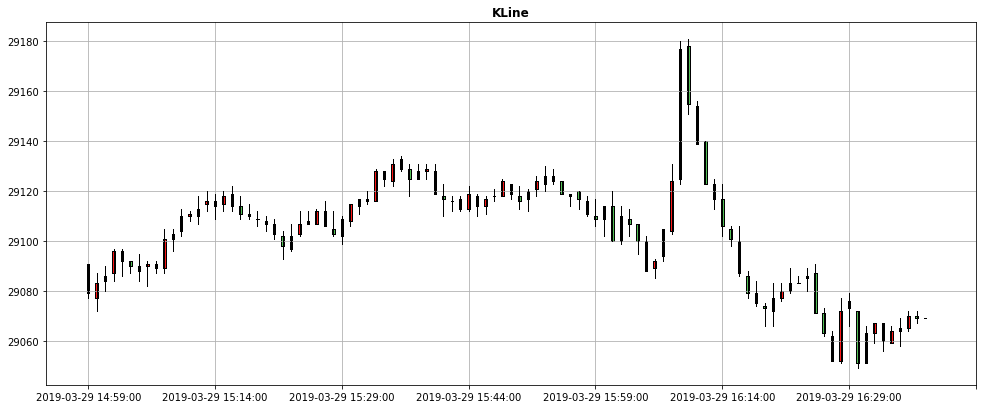

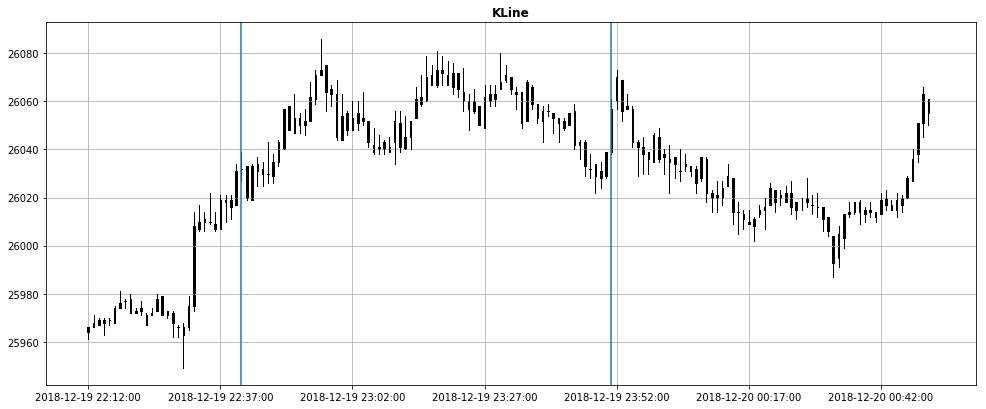

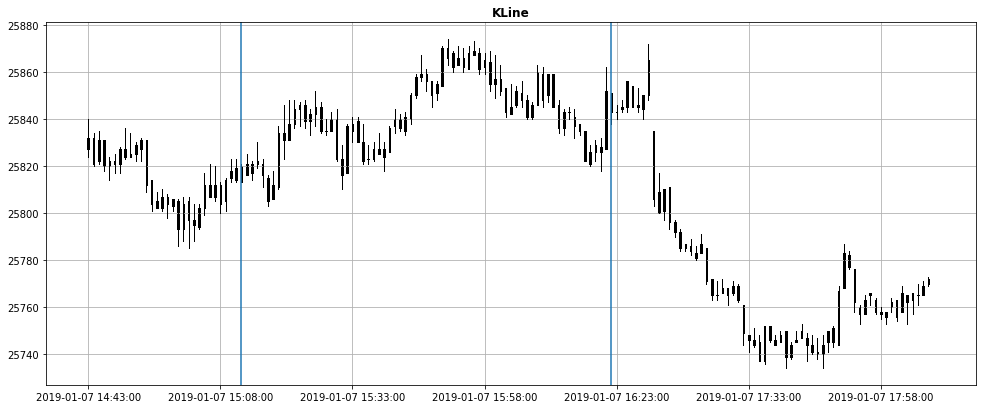

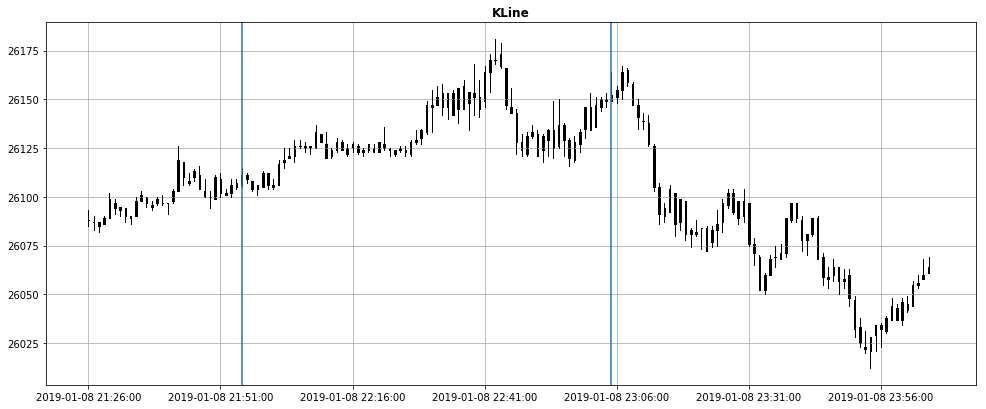

In [9]:
%pylab inline

In [33]:
dt.timedelta(minutes=4)

datetime.timedelta(0, 240)

In [20]:
from matplotlib.lines import Line2D

In [18]:
sys.maxsize

9223372036854775807